In [1]:
import numpy as np
import tensorflow as tf

import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

2023-08-19 09:38:53.534429: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-08-19 09:38:53.534473: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from maddeb.FlowVAEnet import FlowVAEnet
from maddeb.utils import listdir_fullpath
import seaborn as sns

In [3]:
linear_norm_coeff = 10000

## Load images

In [7]:
######## List of data samples
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d) if not f.endswith("metadata.npy")]

train_path_isolated_gal = listdir_fullpath(
    "/sps/lsst/users/bbiswas/simulations/CATSIM/isolated_training/"
)
validation_path_isolated_gal = listdir_fullpath(
    "/sps/lsst/users/bbiswas/simulations/CATSIM/isolated_validation/"
)

# Take 1000 images from the first file.
images = np.load(validation_path_isolated_gal[0], allow_pickle=True)

## Convert image to linear normalization
Note that the images were non-linearly normalized before being saved. So do denormalization first.

In [8]:
isolated_images = images['isolated_gal_stamps']

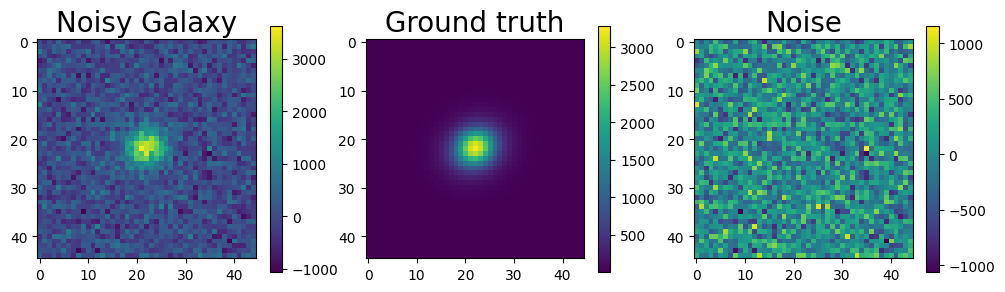

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

image_num = 40

im = axs[0].imshow(images['blended_gal_stamps'][image_num][:, :, 2])
fig.colorbar(im, ax=axs[0], shrink=0.8)
axs[0].set_title("Noisy Galaxy", fontsize=20)

im = axs[1].imshow(images['isolated_gal_stamps'][image_num][:, :, 2])
fig.colorbar(im, ax=axs[1], shrink=0.8)
axs[1].set_title("Ground truth", fontsize=20)


difference = images['blended_gal_stamps'][image_num][:, :, 2] - images['isolated_gal_stamps'][image_num][:, :, 2]
im = axs[2].imshow(difference)
fig.colorbar(im, ax=axs[2],shrink=0.8)
axs[2].set_title("Noise", fontsize=20)
plt.savefig("isolated_galaxy")

In [10]:
images_isolated_normed = np.array(np.array(images['isolated_gal_stamps'].tolist()))/linear_norm_coeff
#images_isolated_normed = np.transpose(images_isolated_normed, axes=(0, 2, 3, 1))

images_blended_normed = np.array(np.array(images['blended_gal_stamps'].tolist()))/linear_norm_coeff
#images_blended_normed = np.transpose(images_blended_normed, axes=(0, 2, 3, 1))

## Load trained models

In [11]:
from maddeb.utils import get_data_dir_path

data_dir = get_data_dir_path()

tf.get_logger().setLevel('ERROR')
latent_dim = 16
num_nf_layers = 8
flow_net = FlowVAEnet(latent_dim=latent_dim, num_nf_layers=num_nf_layers)
flow_net.load_flow_weights(weights_path=os.path.join(data_dir, f"catsim_kl001{latent_dim}d/flow{num_nf_layers}_tanh/val_loss"))
flow_net.load_vae_weights(weights_path=os.path.join(data_dir, f"catsim_kl001{latent_dim}d/deblender/val_loss"))
flow_net.vae_model.trainable=False
print(flow_net.vae_model.summary())
print(flow_net.flow_model.summary())

2023-08-19 09:40:39.727425: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-08-19 09:40:39.727472: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-19 09:40:39.727500: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2023-08-19 09:40:39.727808: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-19 09

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 45, 45, 6)]       0         
_________________________________________________________________
encoder (Functional)         (None, 152)               2586008   
_________________________________________________________________
latent_space (MultivariateNo ((None, 16), (None, 16))  0         
_________________________________________________________________
decoder (Functional)         (None, 45, 45, 6)         2073030   
Total params: 4,659,038
Trainable params: 0
Non-trainable params: 4,659,038
_________________________________________________________________
None
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLa

2023-08-19 09:40:44.756781: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Section 1: Test the VAE

### Section 1.1 reconstructions.
If the VAE is able to correctly reconstruct images, we can conclude that the decoder can be used as a generative model

In [12]:
tf.get_logger().setLevel('ERROR')
model_vae_output_isolated = flow_net.vae_model(images_blended_normed)
model_vae_output_isolated = model_vae_output_isolated

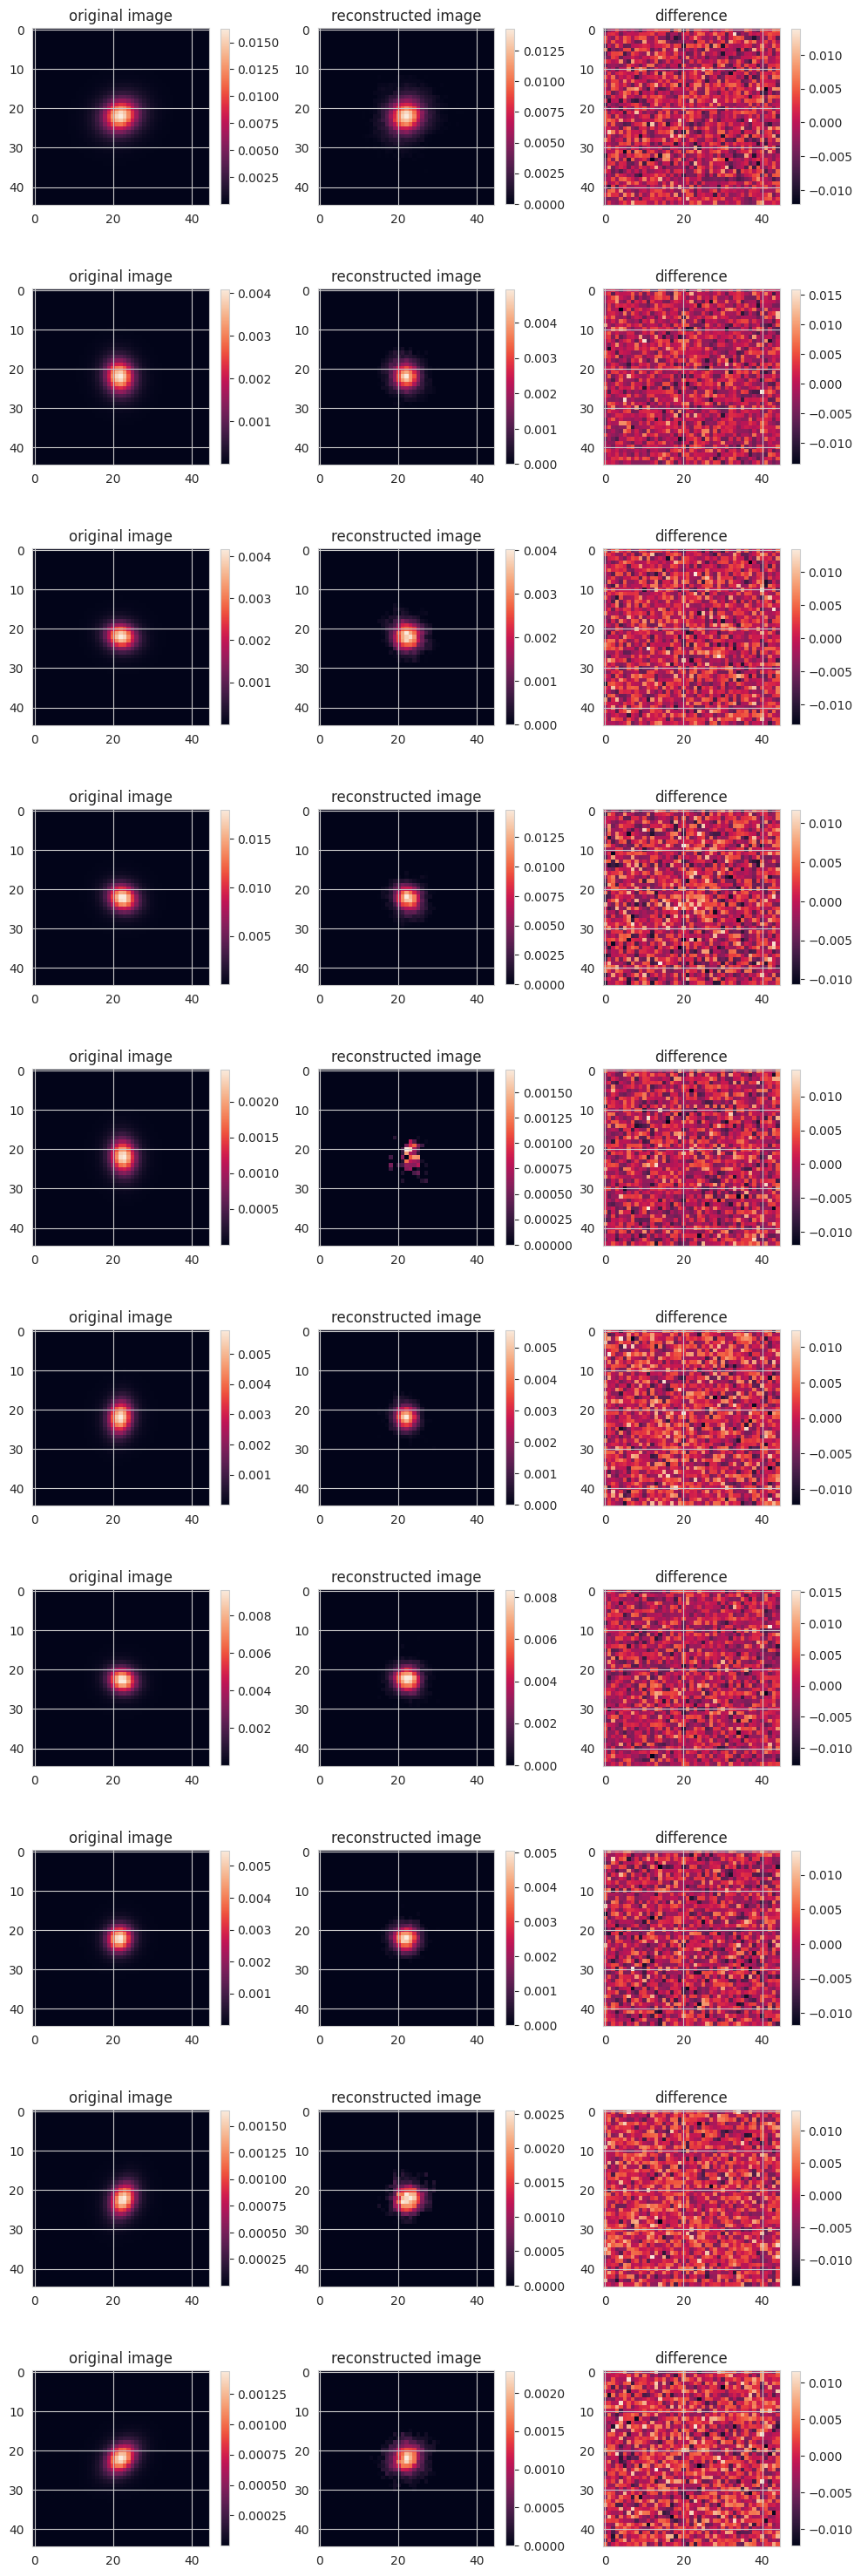

In [13]:
# sns.set_theme(style={"axes.grid": False,
#                      'axes.labelcolor': 'white',
#                      'figure.facecolor': '.15',
#                      'xtick.color': 'white',
#                      'ytick.color': 'white',
#                      'text.color': 'white',
#                      'image.cmap': 'viridis',})

sns.set_style("whitegrid")

fig, axs = plt.subplots(10, 3, figsize=(10,30))

for i in range(10):
    
    image_num = i+40
    band_num = 0
    im = axs[i, 0].imshow(images_isolated_normed[image_num][:, :, band_num])
    fig.colorbar(im, ax=axs[i, 0], shrink=0.8)
    axs[i, 0].set_title("original image")

    im = axs[i, 1].imshow(model_vae_output_isolated.numpy()[image_num][ :, :, band_num])
    fig.colorbar(im, ax=axs[i, 1], shrink=0.8)
    axs[i, 1].set_title("reconstructed image")


    difference = images_blended_normed[image_num][:, :, band_num] - model_vae_output_isolated.numpy()[image_num][ :, :, band_num]
    im = axs[i, 2].imshow(difference)
    fig.colorbar(im, ax=axs[i, 2],shrink=0.8)
    axs[i, 2].set_title("difference")

plt.tight_layout()

In [14]:
import tensorflow_probability as tfp
z = tfp.layers.MultivariateNormalTriL(event_size=latent_dim)(flow_net.encoder(images_isolated_normed))

Conclusion: The reconstructions of galaxies work fairly well! <br>
So the decoder can be used as a generative model by sampling from the latent space.

### Section 1.2 Latent space distribution

In this section we aim to study the latent space distribution of galaxies as learnt by the VAE

In [15]:
images = np.load(validation_path_isolated_gal[0], allow_pickle=True)

In [16]:
latent_vars = []
for i in range(100):
    images_i = np.load(train_path_isolated_gal[i], allow_pickle=True)
    images_isolated_normed = np.array(np.array(images_i['blended_gal_stamps'].tolist()))/linear_norm_coeff
    #images_isolated_normed = np.transpose(images_isolated_normed, axes=(0, 2, 3, 1))
    
    z = tfp.layers.MultivariateNormalTriL(event_size=latent_dim)(flow_net.encoder(images_isolated_normed))

    latent_vars.extend(list(z.sample().numpy()))
latent_vars = np.array(latent_vars)

In [17]:
latent_vars_list =[]
for i in range(latent_dim):
    latent_vars_list.append(latent_vars[:, i])

In [18]:
print(len(latent_vars_list))

16


Text(0, 0.5, 'distribution')

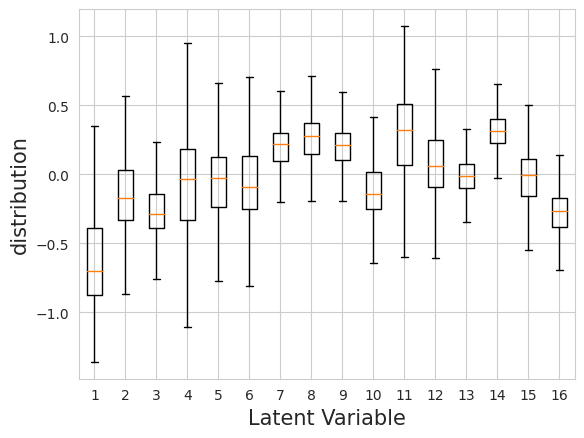

In [19]:
plt.boxplot(latent_vars_list, showfliers=False)
plt.xlabel("Latent Variable", fontsize=15)
plt.ylabel("distribution", fontsize=15)

The plot shows the distribution of the latent space variables as learnt by the VAE. <br>
In the next section we will try to see if we can model this distribution using the Normalizing Flow network. 

# Section 2. Test the flow network

### Section 2.1 Likelihood distribution

In this section, we will test if the flow network assigns high probability to data it had seen trained on relative to unseen galaxies.

In [21]:
train_path_blended_gal = listdir_fullpath(
    "/sps/lsst/users/bbiswas/simulations/CATSIM/blended_training/"
)
validation_path_blended_gal = listdir_fullpath(
    "/sps/lsst/users/bbiswas/simulations/CATSIM/blended_validation/"
)
# Take 1000 images from the first file.
images_blended = np.load(validation_path_blended_gal[0], allow_pickle=True)

In [22]:
images_isolated_normed = np.array(np.array(images_blended['isolated_gal_stamps'].tolist()))/linear_norm_coeff
#images_isolated_normed = np.transpose(images_isolated_normed, axes=(0, 2, 3, 1))

images_blended_normed = np.array(np.array(images_blended['blended_gal_stamps'].tolist()))/linear_norm_coeff
#images_blended_normed = np.transpose(images_blended_normed, axes=(0, 2, 3, 1))

In [23]:
isolated_likelihood = flow_net.flow_model(images_isolated_normed)
blended_likelihood = flow_net.flow_model(images_blended_normed)

likelihood_difference=isolated_likelihood-blended_likelihood

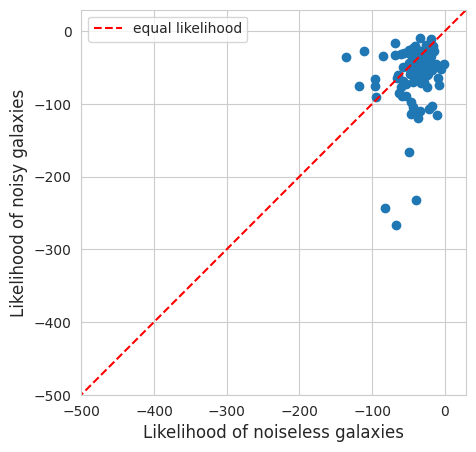

In [24]:
fig = plt.figure(figsize=(5,5))
plt.scatter(isolated_likelihood, blended_likelihood)
max_lim = max(np.amax(isolated_likelihood), np.amax(blended_likelihood))
min_lim = min(np.amin(isolated_likelihood), np.amin(blended_likelihood))
plt.xlim(-500, max_lim+30)
plt.ylim(-500, max_lim+30)
plt.plot((min_lim, max_lim+300), (min_lim, max_lim+300), ls="--", c="r", label="equal likelihood")
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel("Likelihood of noiseless galaxies", fontsize=12)
plt.ylabel("Likelihood of noisy galaxies", fontsize=12)
plt.legend()

we observe from the result here that the likelihood of noiseless galaxies is higher than that of blended/noisy ones.

In [25]:
#plt.hist(likelihood_difference.numpy(), bins=30);

### Section 2.2 Learnt latent space distribution

Finally, let's try to see the distribution of latent variables learnt by the normalizing flow:

In [26]:
sampled_latent_vars = flow_net.td.sample(len(latent_vars_list[0]), seed = 13).numpy()
sampled_latent_vars_list =[]
for i in range(latent_dim):
    sampled_latent_vars_list.append(sampled_latent_vars[:, i])

In [27]:
print(len(sampled_latent_vars))

20000


On comparing the sampled latent space distribution with the actual distribution, we see by eye that the flow nework is able to learn the complex distribution in the latent space.

In [28]:
latent_value=[]
latent_var_num=[]
latent_type=[]

for i in range(latent_dim):
    latent_value.extend(list(latent_vars_list[i]))
    latent_var_num.extend([i]*len(latent_vars_list[i]))
    latent_type.extend(["actual"]*len(latent_vars_list[i]))
    
    latent_value.extend(list(sampled_latent_vars_list[i]))
    latent_var_num.extend([i]*len(sampled_latent_vars_list[i]))
    latent_type.extend(["learnt"]*len(sampled_latent_vars_list[i]))
    
df_plot ={"latent_value": latent_value, "latent_var_num":latent_var_num, "latent_type":latent_type}

In [29]:
import pandas as pd
df_plot = pd.DataFrame(df_plot)

In [30]:
df_plot

,latent_value,latent_var_num,latent_type
0,-0.178545,0,actual
1,-0.810020,0,actual
2,-0.366549,0,actual
3,-0.477767,0,actual
4,-0.574562,0,actual
...,...,...,...
639995,0.045211,15,learnt
639996,0.007060,15,learnt
639997,-0.065006,15,learnt
639998,-0.008034,15,learnt


Text(0, 0.5, 'distribution')

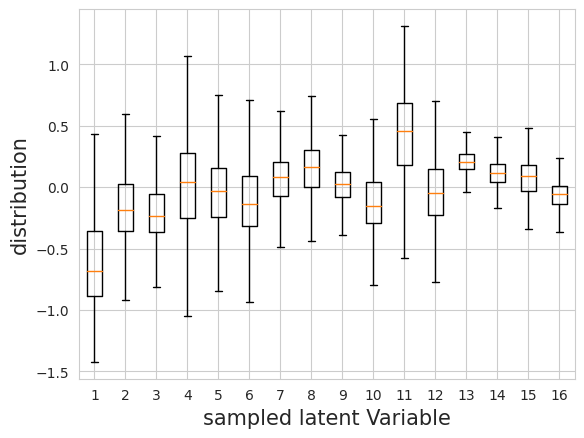

In [31]:
plt.boxplot(sampled_latent_vars_list, showfliers=False);
plt.xlabel("sampled latent Variable", fontsize=15)
plt.ylabel("distribution", fontsize=15)

In [32]:
import seaborn as sns

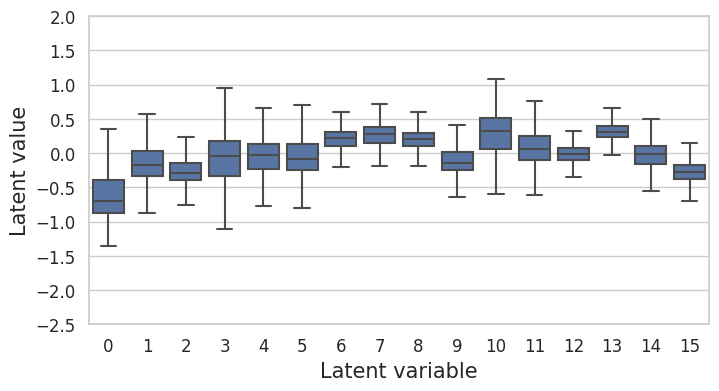

In [33]:
sns.set_theme(style={'text.color': 'black'})
f, ax = plt.subplots(figsize=(8, 4))
ax = sns.boxplot(data=df_plot[df_plot["latent_type"]=="actual"], x="latent_var_num", y="latent_value", showfliers=False, color="b")
ax.set_ylim(-2.5,2,5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Latent variable", fontsize=15)
ax.set_ylabel("Latent value", fontsize=15)

plt.savefig("results/latent_boxplot")
plt.savefig("results/latent_boxplot.pdf", bbox_inches = 'tight')

In [34]:
np.shape(np.concatenate((latent_vars_list[0], sampled_latent_vars_list[0])))

(40000,)

In [35]:
latent_vars_list[0]

array([-0.17854504, -0.81002027, -0.3665489 , ...,  0.86625415,
       -0.6603728 ,  2.007182  ], dtype=float32)

In [36]:
latent_value=[]
latent_var_num=[]
latent_type=[]

df_sns = {}

for i in range(5):
    df_sns["Variable " + str(i + 1)] = np.concatenate((latent_vars_list[i], sampled_latent_vars_list[i]))

df_sns["latent type"] = ["actual distribution"]*len(latent_vars_list[i]) + ["learnt distribution"]*len(sampled_latent_vars_list[i])
df_sns = pd.DataFrame(df_sns)

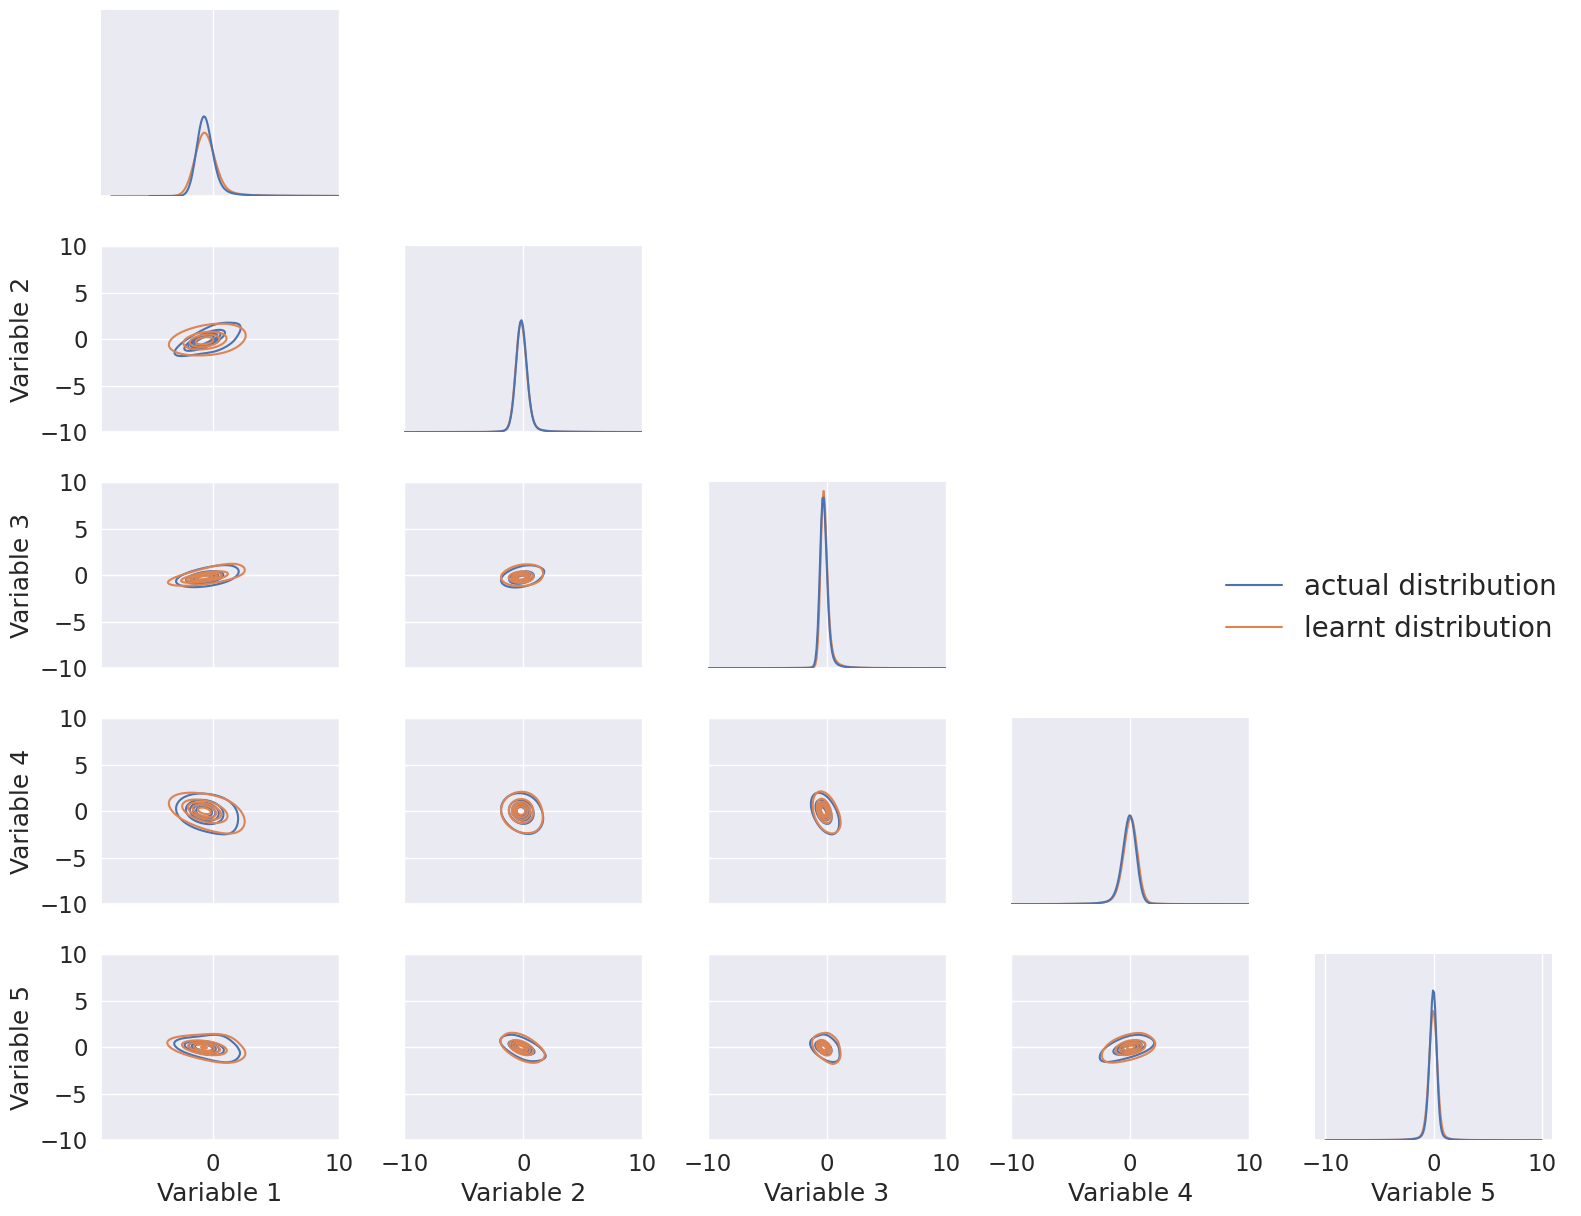

In [37]:
sns.set(font_scale=1.5)

g = sns.PairGrid(df_sns, hue="latent type", corner=True)

g.map_lower(sns.kdeplot, clip=[-10, 10], levels=6)
g.map_diag(sns.kdeplot, clip=[-10, 10])

g.add_legend(fontsize=20, title="")
plt.tight_layout()

plt.savefig("results/latent_distribution_correlation")
plt.savefig("results/latent_distribution_correlation.pdf", bbox_inches = 'tight')

# Test VAE as deblender

In [38]:
tf.get_logger().setLevel('ERROR')
model_vae_output_isolated = flow_net.vae_model(images_blended_normed)
model_vae_output_isolated = model_vae_output_isolated

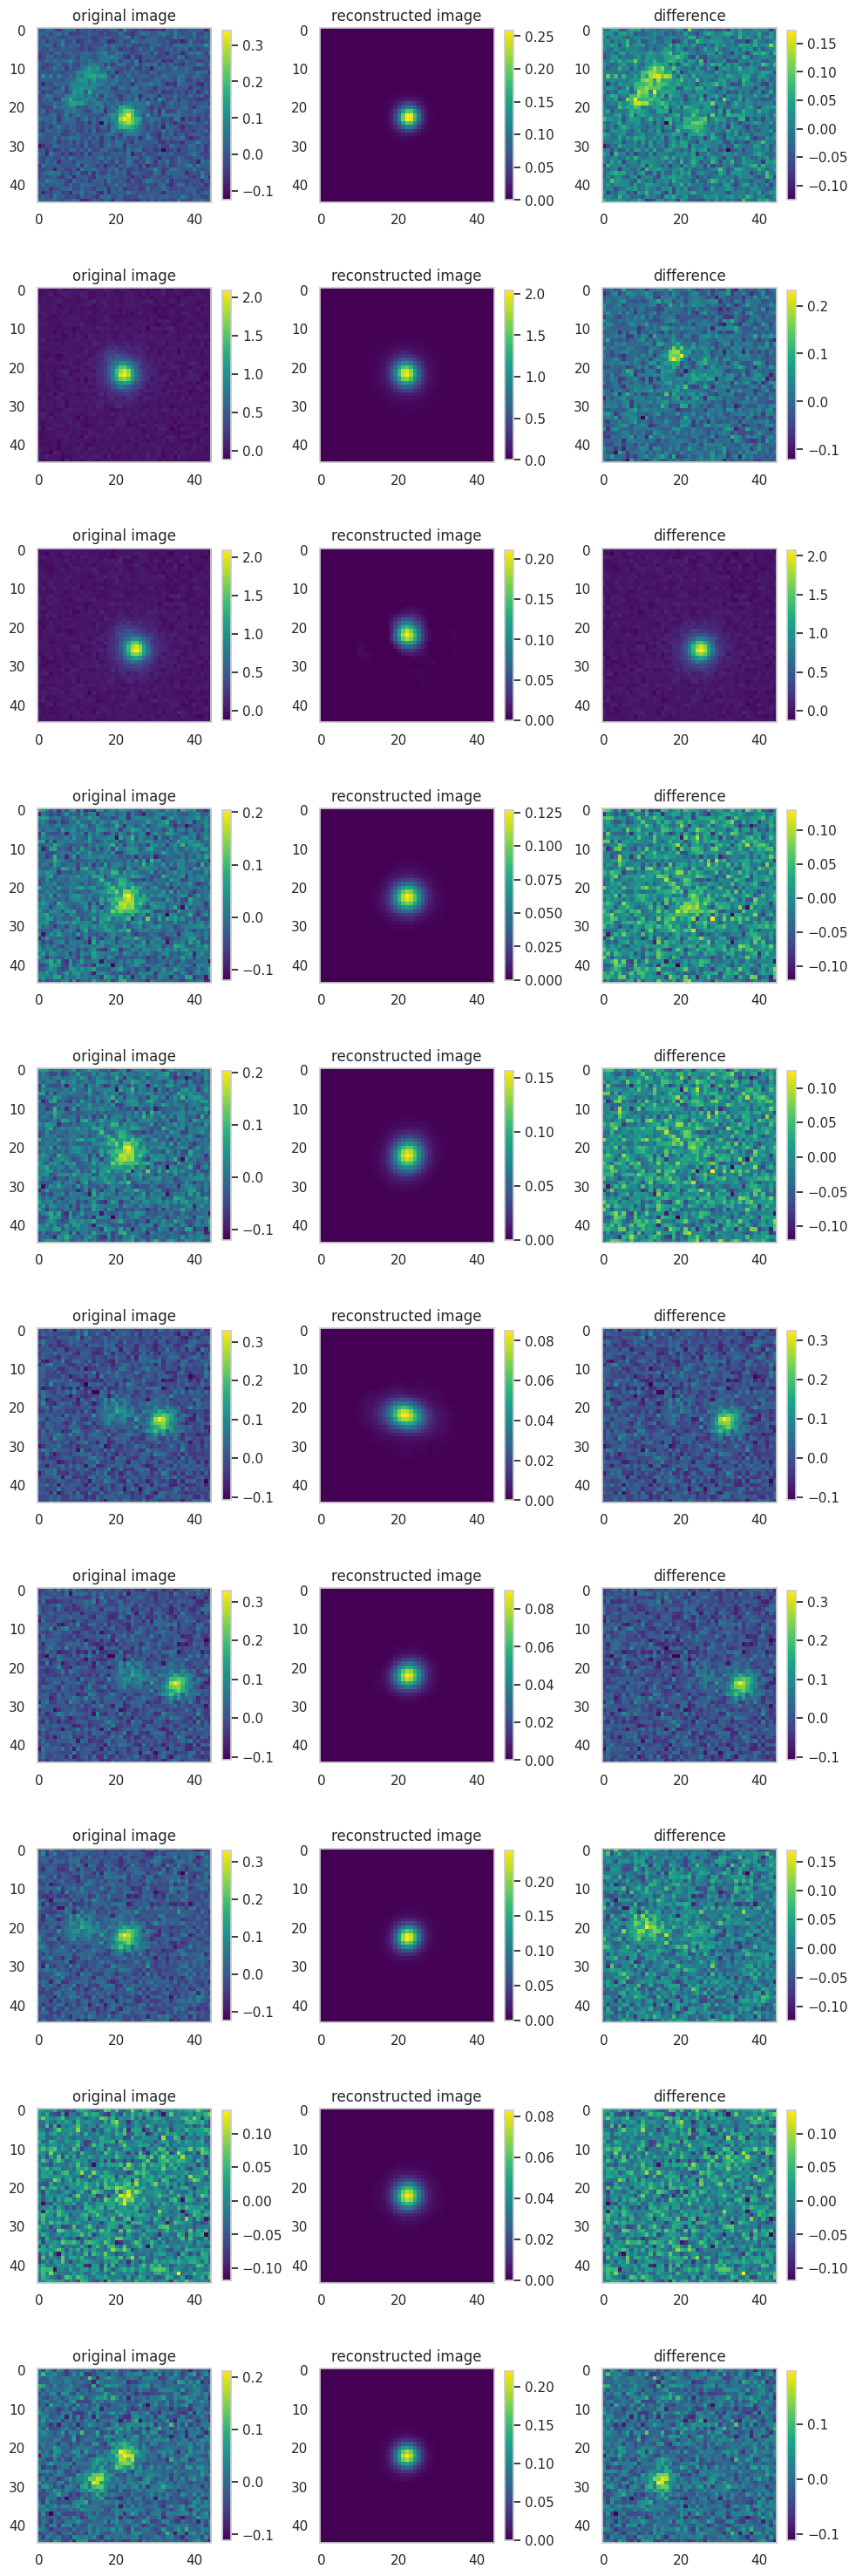

In [39]:
# sns.set_theme(style={"axes.grid": False,
#                      'axes.labelcolor': 'white',
#                      'figure.facecolor': '.15',
#                      'xtick.color': 'white',
#                      'ytick.color': 'white',
#                      'text.color': 'white',
#                      'image.cmap': 'viridis',})

sns.set_style("whitegrid")
sns.set_theme(style={"axes.grid": False,
                     'image.cmap': 'viridis',})
fig, axs = plt.subplots(10, 3, figsize=(10,30))

for i in range(10):
    
    image_num = i+40
    band_num = 2
    im = axs[i, 0].imshow(images_blended_normed[image_num][:, :, band_num])
    fig.colorbar(im, ax=axs[i, 0], shrink=0.8)
    axs[i, 0].set_title("original image")

    im = axs[i, 1].imshow(model_vae_output_isolated.numpy()[image_num][ :, :, band_num])
    fig.colorbar(im, ax=axs[i, 1], shrink=0.8)
    axs[i, 1].set_title("reconstructed image")


    difference = images_blended_normed[image_num][:, :, band_num] - model_vae_output_isolated.numpy()[image_num][ :, :, band_num]
    im = axs[i, 2].imshow(difference)
    fig.colorbar(im, ax=axs[i, 2],shrink=0.8)
    axs[i, 2].set_title("difference")

plt.tight_layout()

##### 

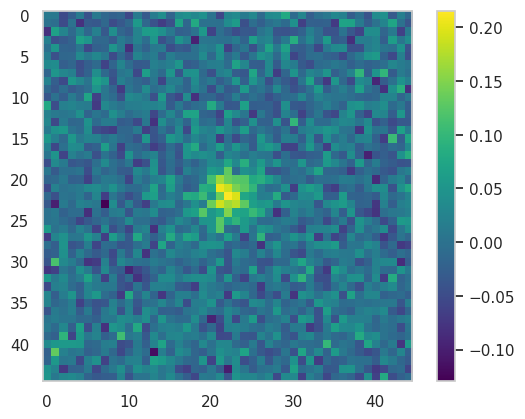

In [40]:
image_num = 30
im = plt.imshow(images_blended_normed[image_num][:, :, 2]);
ax=plt.gca()
plt.colorbar(im, ax=ax)

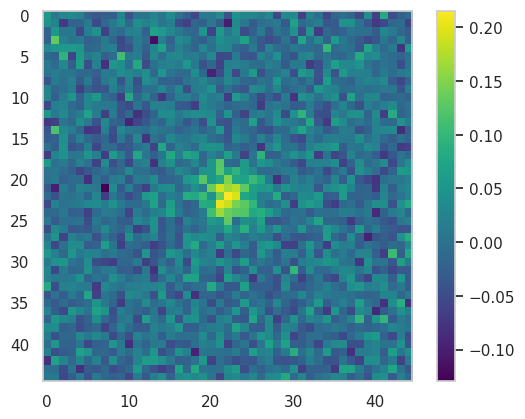

In [41]:
flipped = np.flip(images_blended_normed, axis=1)
plt.imshow(flipped[30, :, :, 2])
ax=plt.gca()
plt.colorbar(im, ax=ax)

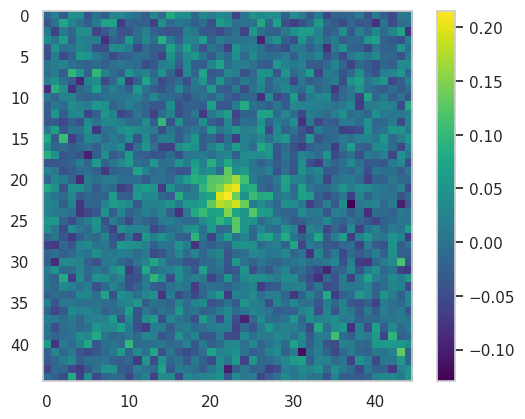

In [42]:
flipped = np.flip(images_blended_normed, axis=2)
plt.imshow(flipped[30, :, :, 2])
ax=plt.gca()
plt.colorbar(im, ax=ax)

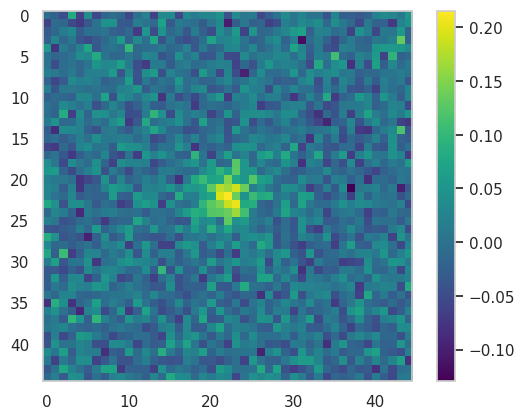

In [43]:
flipped = np.flip(np.flip(images_blended_normed, axis=1), axis=2)
plt.imshow(flipped[30, :, :, 2])
ax=plt.gca()
plt.colorbar(im, ax=ax)